In [1]:
import sys; sys.path.append("/home/choij/workspace/ChargedHiggsAnalysis/libPython")
from sklearn.utils import shuffle
from ROOT import TFile, TH1D
from Preprocess import rtfileToDataList, GraphDataset
from torch_geometric.loader import DataLoader

WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysis"
CHANNEL = "Skim3Mu"
SIG = "MHc-130_MA-90"
BKG = "ttX"

# load dataset
# load dataset
rtSig = TFile.Open(f"{WORKDIR}/data/Combined/{CHANNEL}__/{SIG}.root")
rtBkg = TFile.Open(f"{WORKDIR}/data/Combined/{CHANNEL}__/{BKG}.root")
sigDataList = shuffle(rtfileToDataList(rtSig, isSignal=True, maxSize=20000), random_state=42); rtSig.Close()
bkgDataList = shuffle(rtfileToDataList(rtBkg, isSignal=False, maxSize=20000), random_state=42); rtBkg.Close()
dataList = shuffle(sigDataList+bkgDataList, random_state=42)

trainset = GraphDataset(dataList[:int(len(dataList)*0.6)])
validset = GraphDataset(dataList[int(len(dataList)*0.6):int(len(dataList)*0.7)])
testset  = GraphDataset(dataList[int(len(dataList)*0.7):])

trainLoader = DataLoader(trainset, batch_size=1024, shuffle=True, pin_memory=True)
validLoader = DataLoader(validset, batch_size=1024, shuffle=False, pin_memory=True)
testLoader = DataLoader(testset, batch_size=1024, shuffle=False, pin_memory=True)

Welcome to JupyROOT 6.26/08
@@@@ no. of dataList ends with 20000
@@@@ no. of dataList ends with 20000


In [2]:
import numpy as np
import pandas as pd

def readFitness(SIG, BKG):
    BASEDIR = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}"
    fitnessDict = {}
    for i in range(5):
        csv = pd.read_csv(f"{BASEDIR}/CSV/GAOptimGen{i}.csv").transpose()
        thisFitness = []
        for idx in csv.index: thisFitness.append(float(csv.loc[idx, 'fitness']))
        fitnessDict[f"Gen{i}"] = thisFitness

    return fitnessDict

def getChromosomes(SIG, BKG):
    # get mean fitness values
    fitness = readFitness(SIG, BKG)
    meanFitness = {}
    for key, value in fitness.items(): meanFitness[key] = np.mean(value)

    # choose lowest mean fitness generation
    minFitness = sorted(meanFitness.items(), key=lambda item: item[1])[0]
    gen = minFitness[0]

    # read csv file
    BASEDIR = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}"
    csv = pd.read_csv(f"{BASEDIR}/CSV/GAOptim{gen}.csv").transpose()

    return csv

In [3]:
import torch
from Models import ParticleNet, ParticleNetLite

csv = getChromosomes(SIG, BKG)
models = {}
for idx in csv.index:
    modelName, optimizer, initLR, scheduler = eval(csv.loc[idx, 'chromosome'])
    modelPath = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}/models/{modelName}_{optimizer}_initLR-{str(initLR).replace('.', 'p')}_{scheduler}.pt"
    if modelName == "ParticleNet": model = ParticleNet(9, 2)
    else:                          model = ParticleNetLite(9, 2)
    model.load_state_dict(torch.load(modelPath, map_location=torch.device('cpu')))

    models[idx] = model

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt

def saveROC(model, idx):
    model.eval()

    plt.figure(figsize=(12, 12))
    plt.title("ROC curve")

    # train
    predictions = []
    answers = []
    with torch.no_grad():
        for data in trainLoader:
            pred = model(data.x, data.edge_index, data.batch)
            for p in pred:
                predictions.append(p[1].numpy())
            for a in data.y:
                answers.append(a.numpy())
    predictions = np.array(predictions)
    answers = np.array(answers)
    fpr, tpr, _ = metrics.roc_curve(answers, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(tpr, 1.-fpr, 'r--', label=f"train ROC ({auc:.3f})")

    predictions = []
    answers = []
    with torch.no_grad():
        for data in validLoader:
            pred = model(data.x, data.edge_index, data.batch)
            for p in pred:
                predictions.append(p[1].numpy())
            for a in data.y:
                answers.append(a.numpy())
    predictions = np.array(predictions)
    answers = np.array(answers)
    fpr, tpr, _ = metrics.roc_curve(answers, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(tpr, 1.-fpr, 'g--', label=f"valid ROC ({auc:.3f})")

    predictions = []
    answers = []
    with torch.no_grad():
        for data in testLoader:
            pred = model(data.x, data.edge_index, data.batch)
            for p in pred:
                predictions.append(p[1].numpy())
            for a in data.y:
                answers.append(a.numpy())
    predictions = np.array(predictions)
    answers = np.array(answers)
    fpr, tpr, _ = metrics.roc_curve(answers, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(tpr, 1.-fpr, 'b--', label=f"train ROC ({auc:.3f})")

    plt.legend(loc='best')
    plt.xlabel('sig eff.')
    plt.ylabel('bkg rej.')
    plt.savefig(f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}/plots/ROC_model{idx}.png")

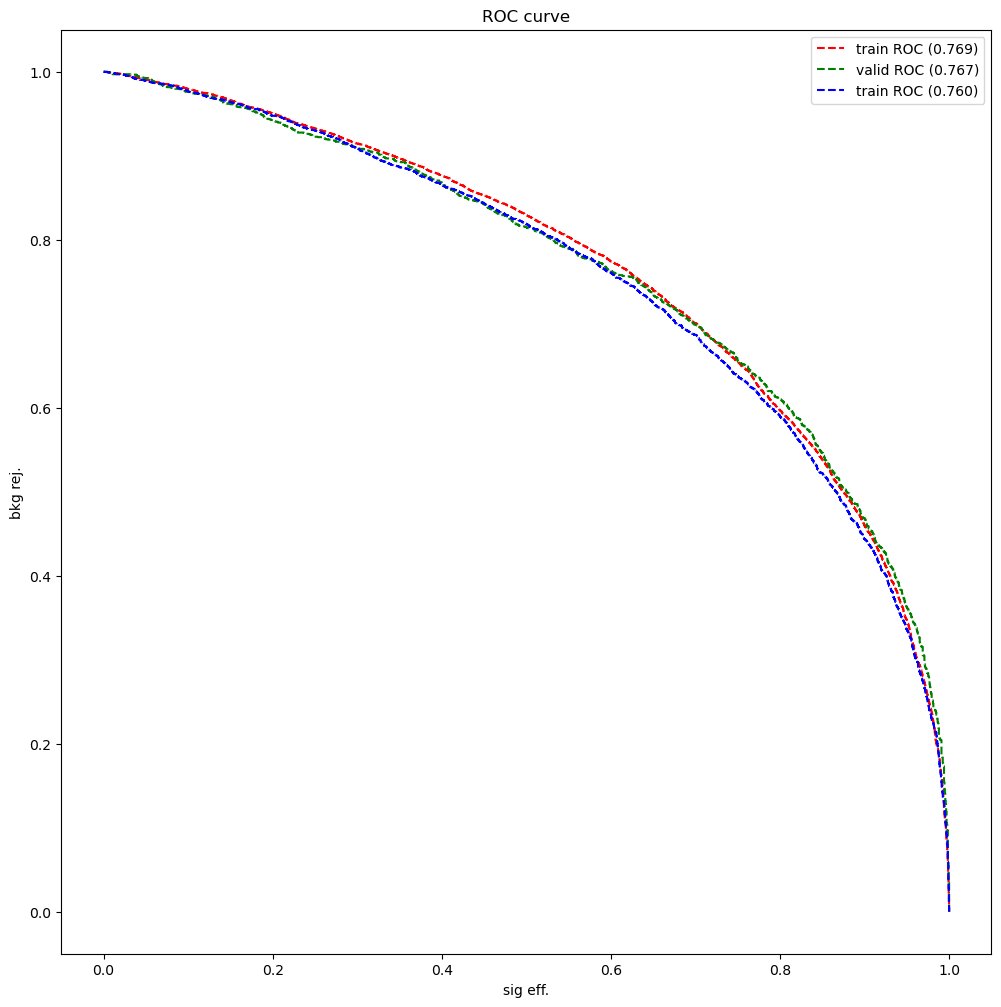

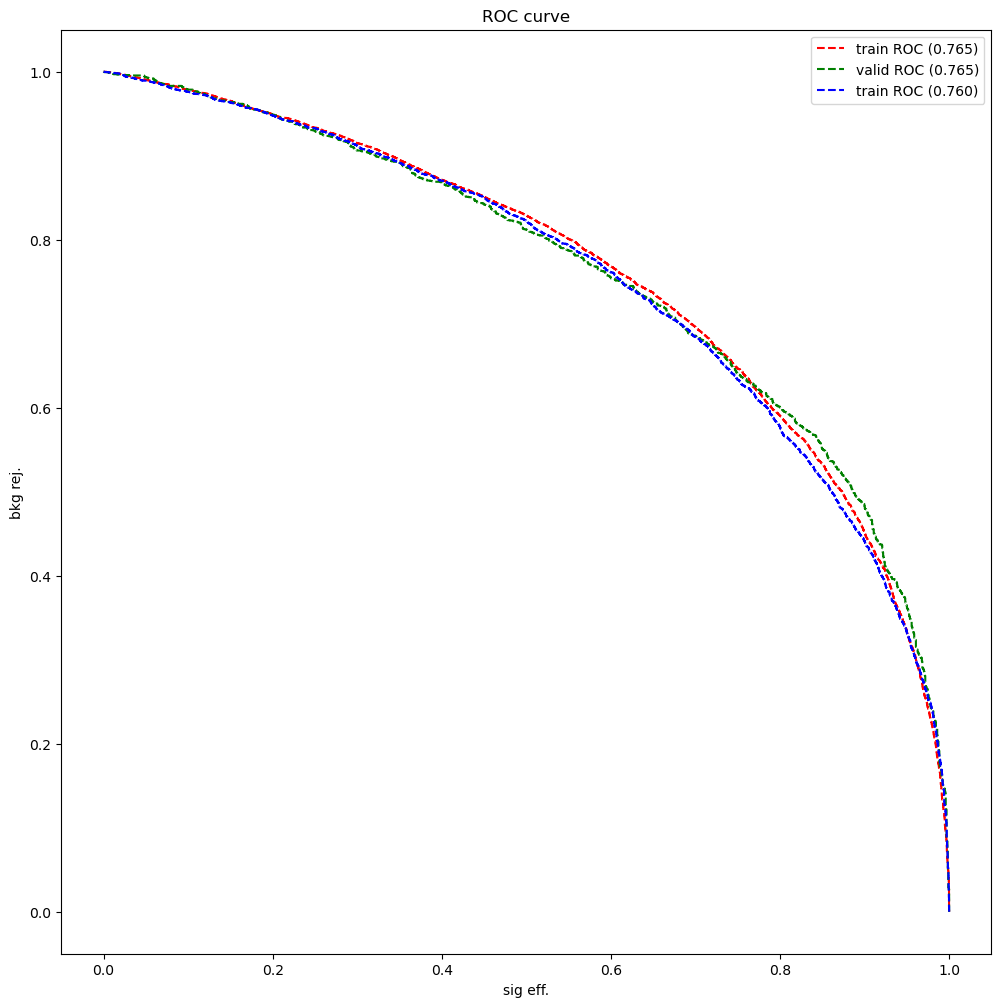

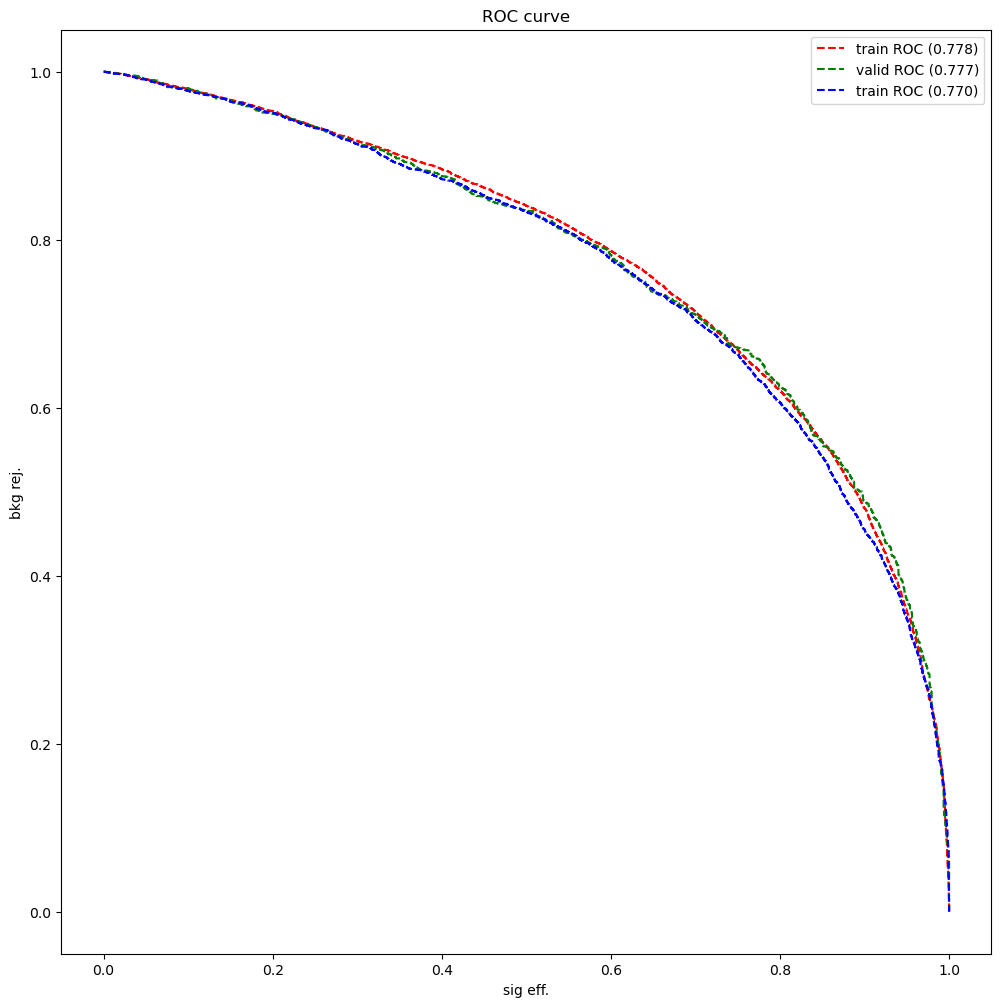

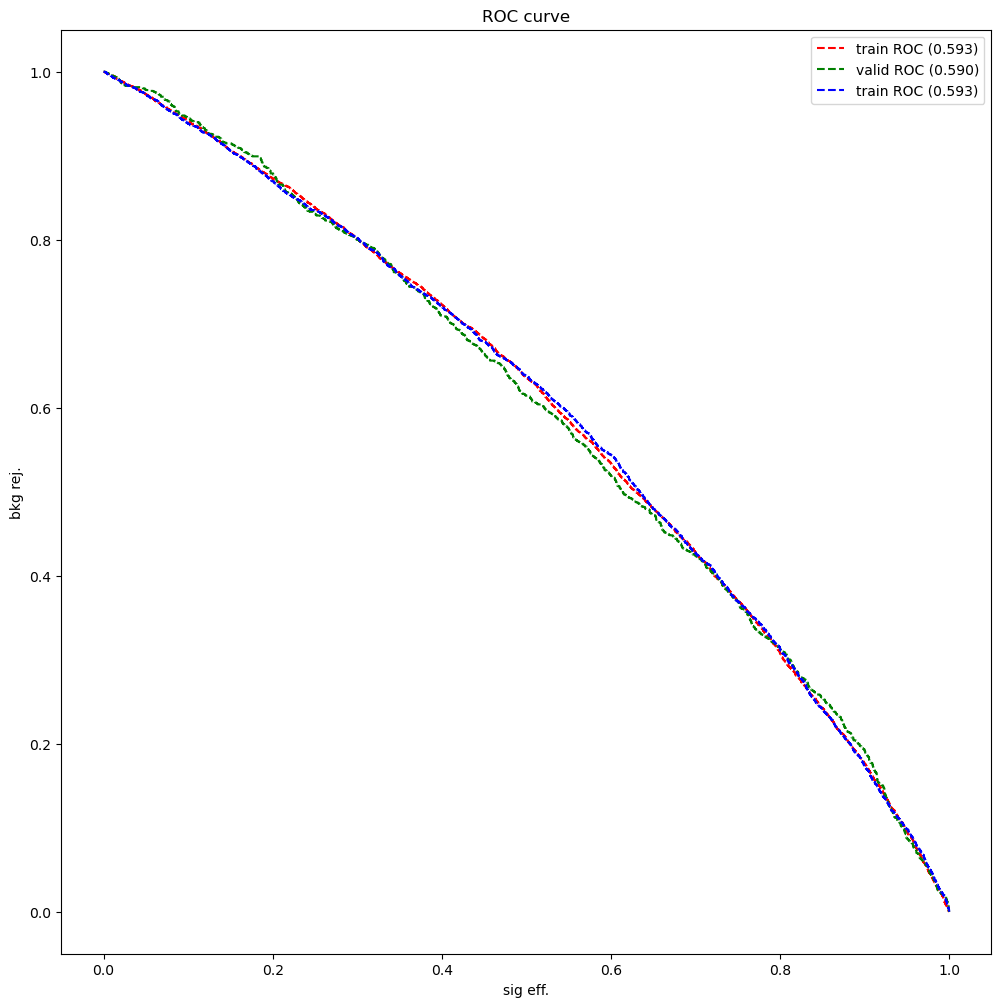

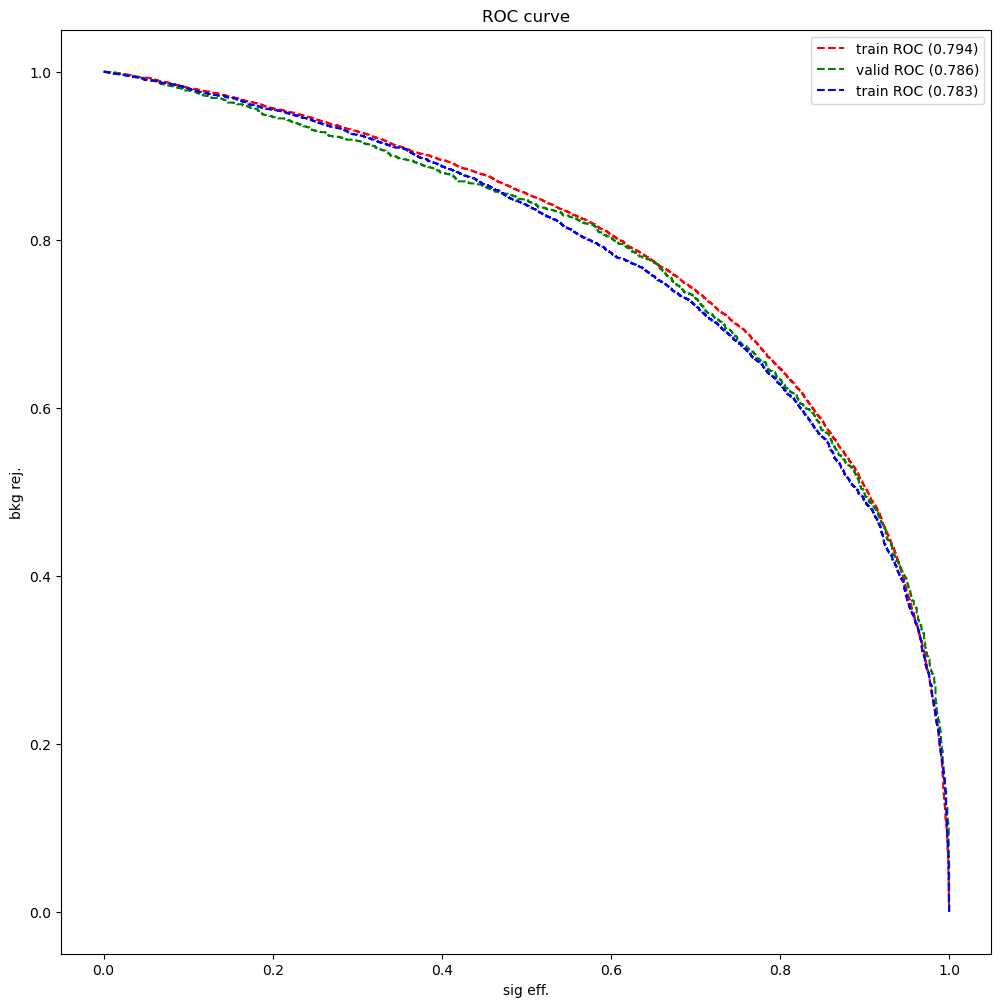

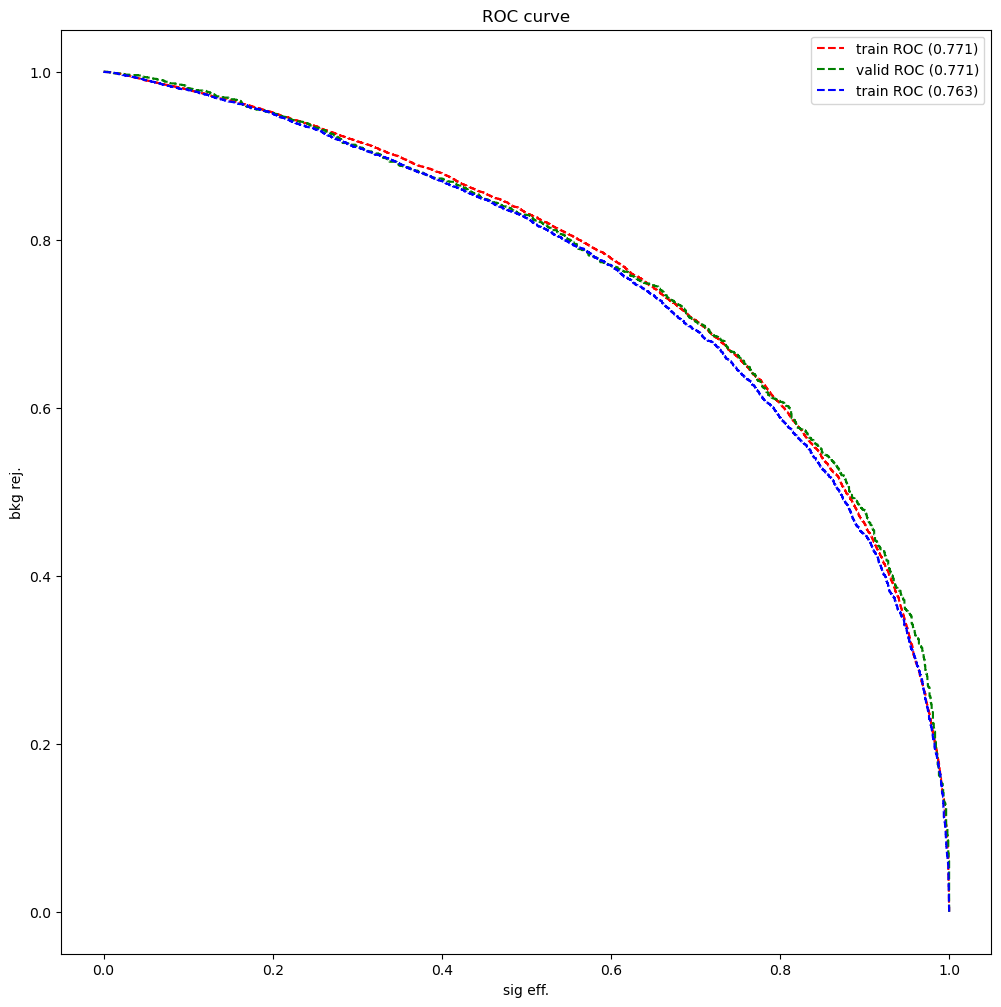

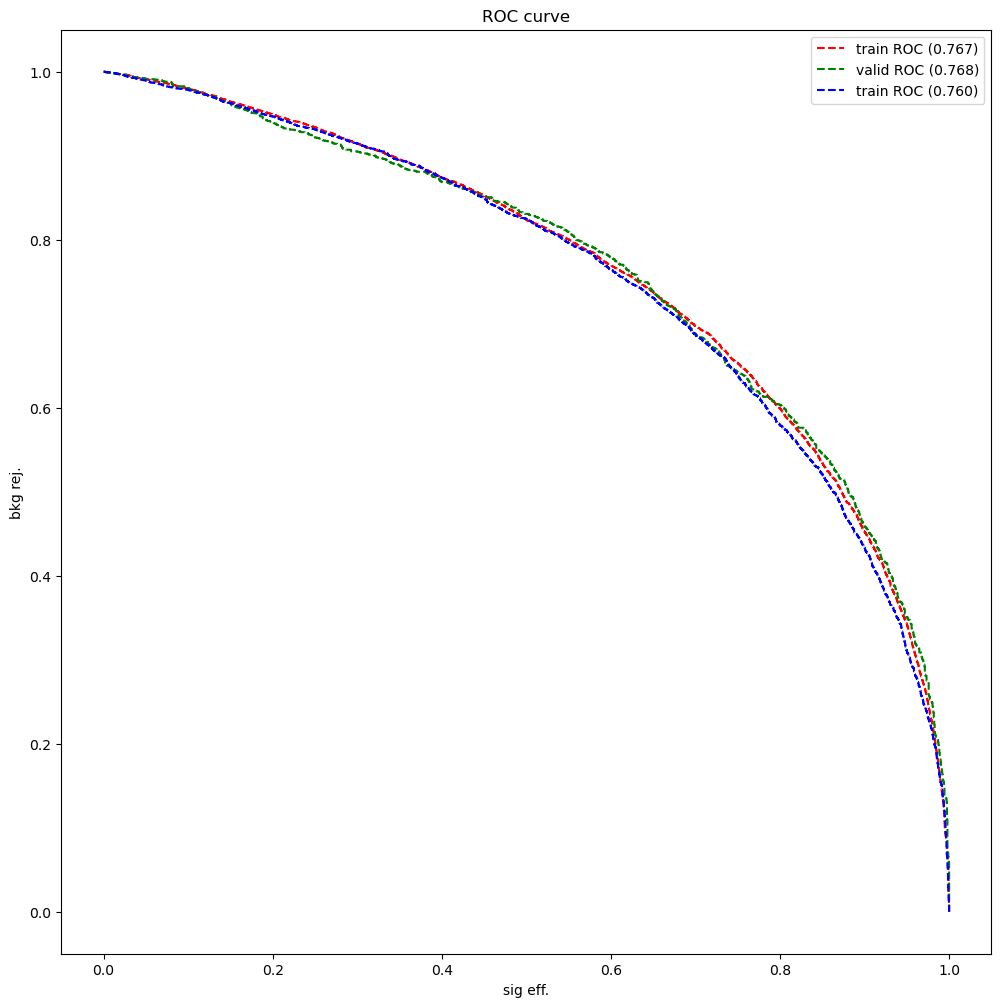

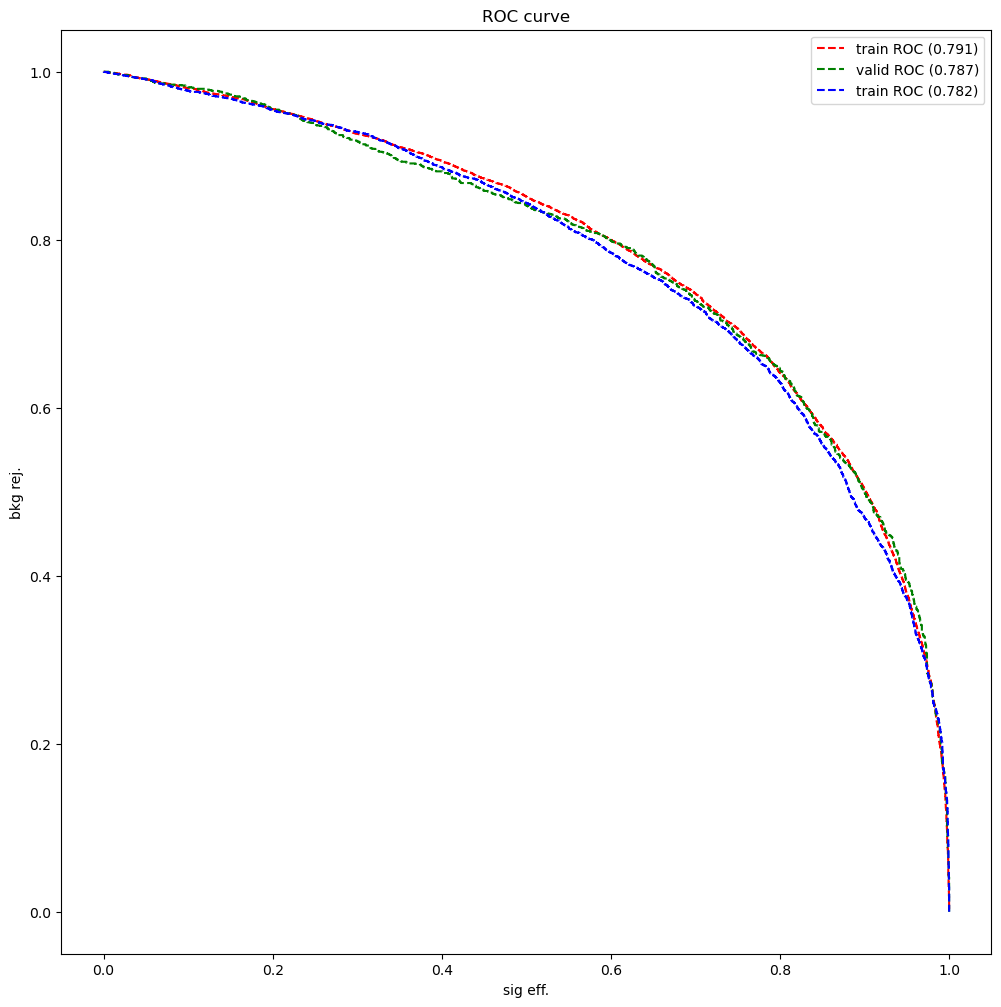

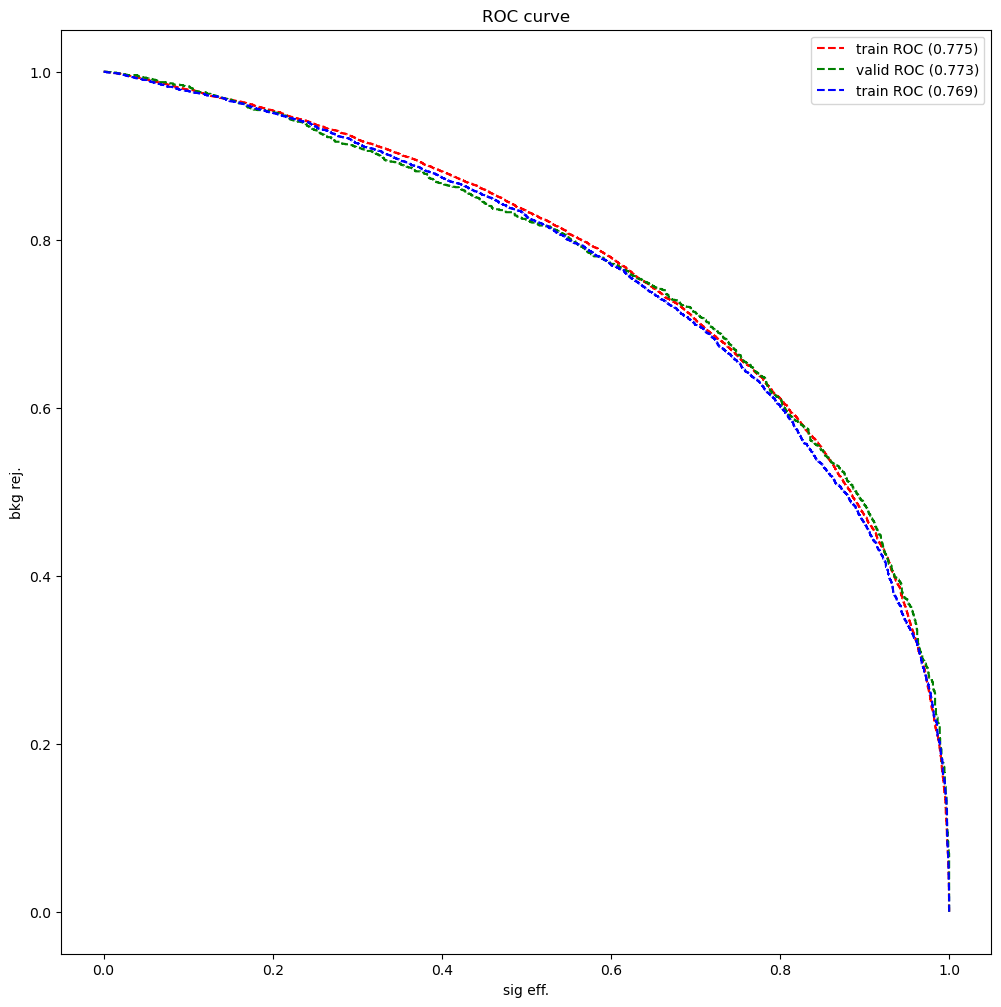

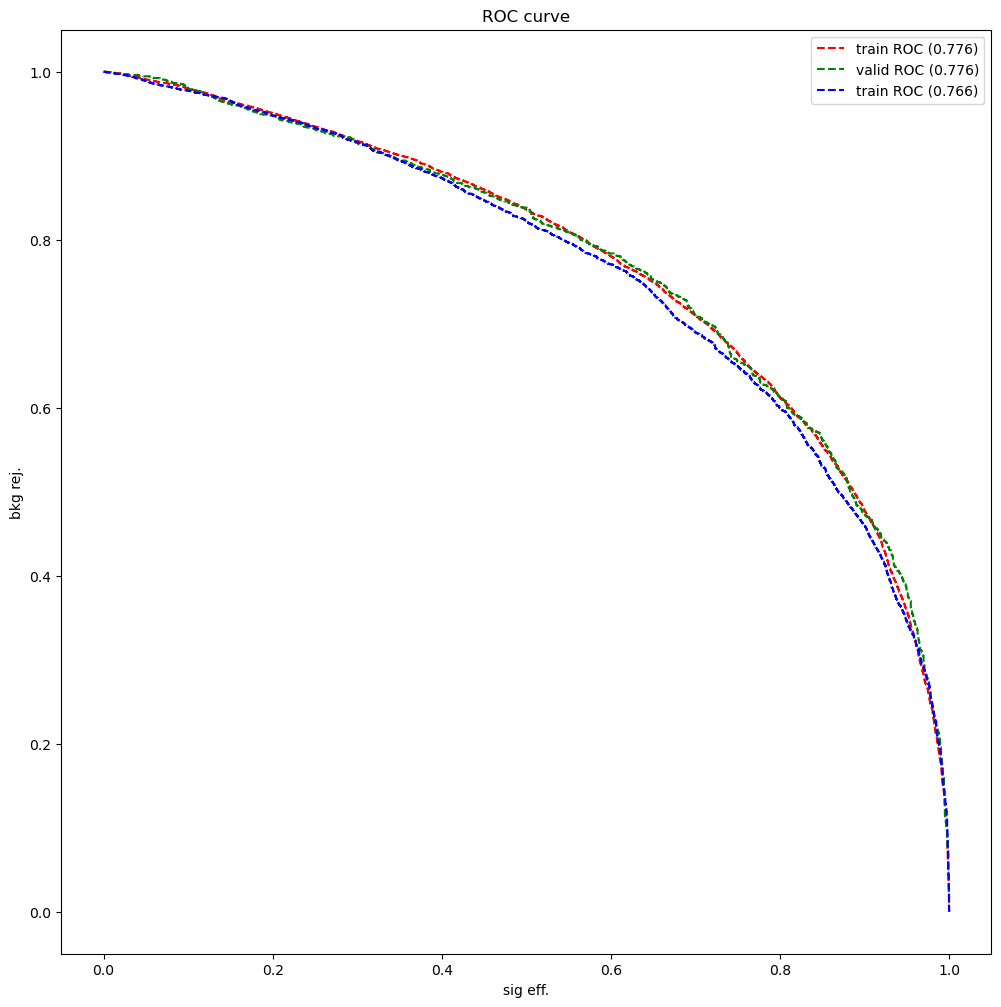

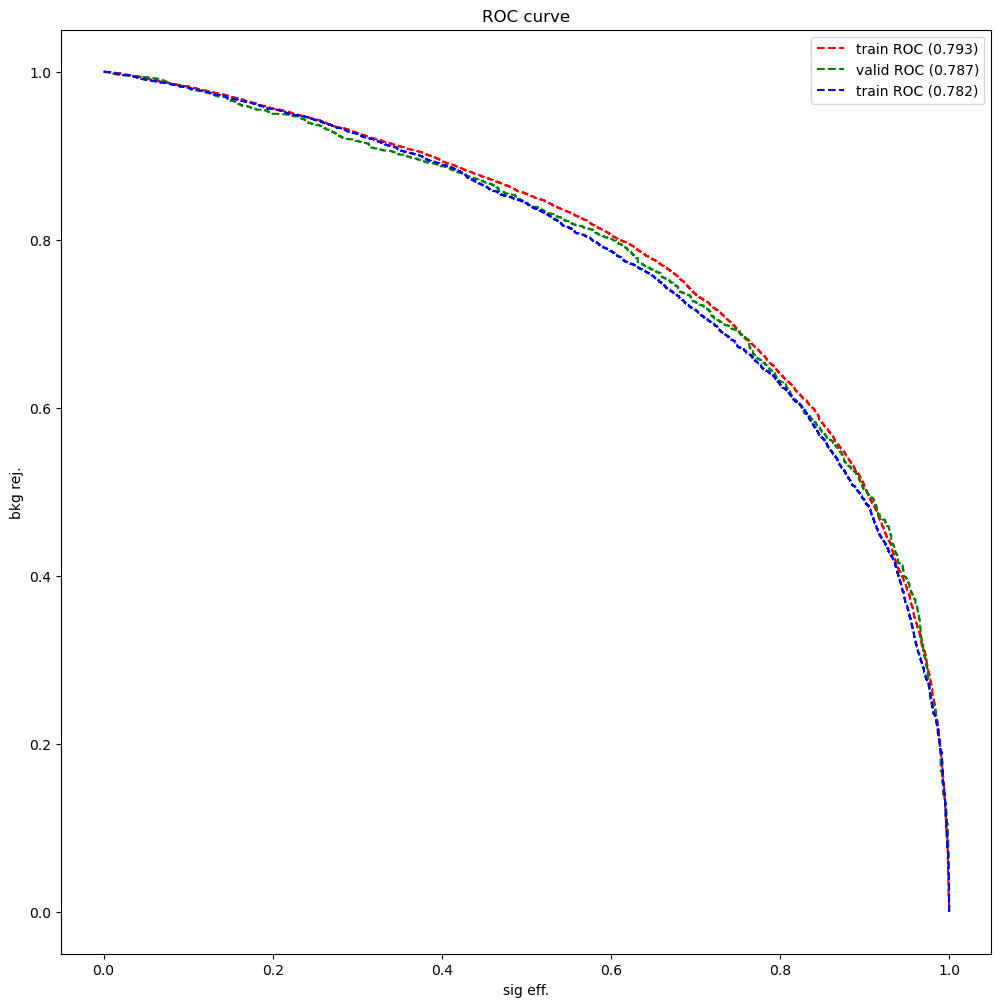

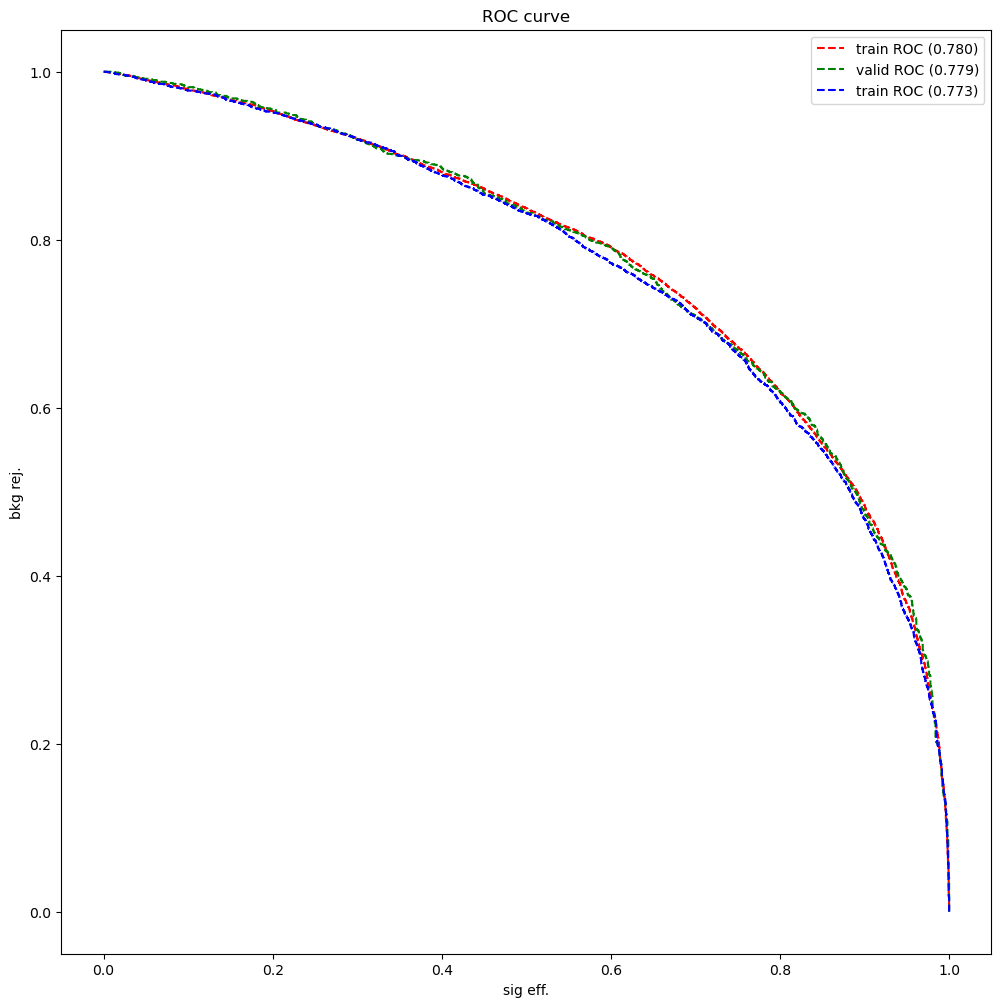

In [26]:
import os
os.makedirs(f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}/plots")

for idx, model in models.items():
    saveROC(model, idx)

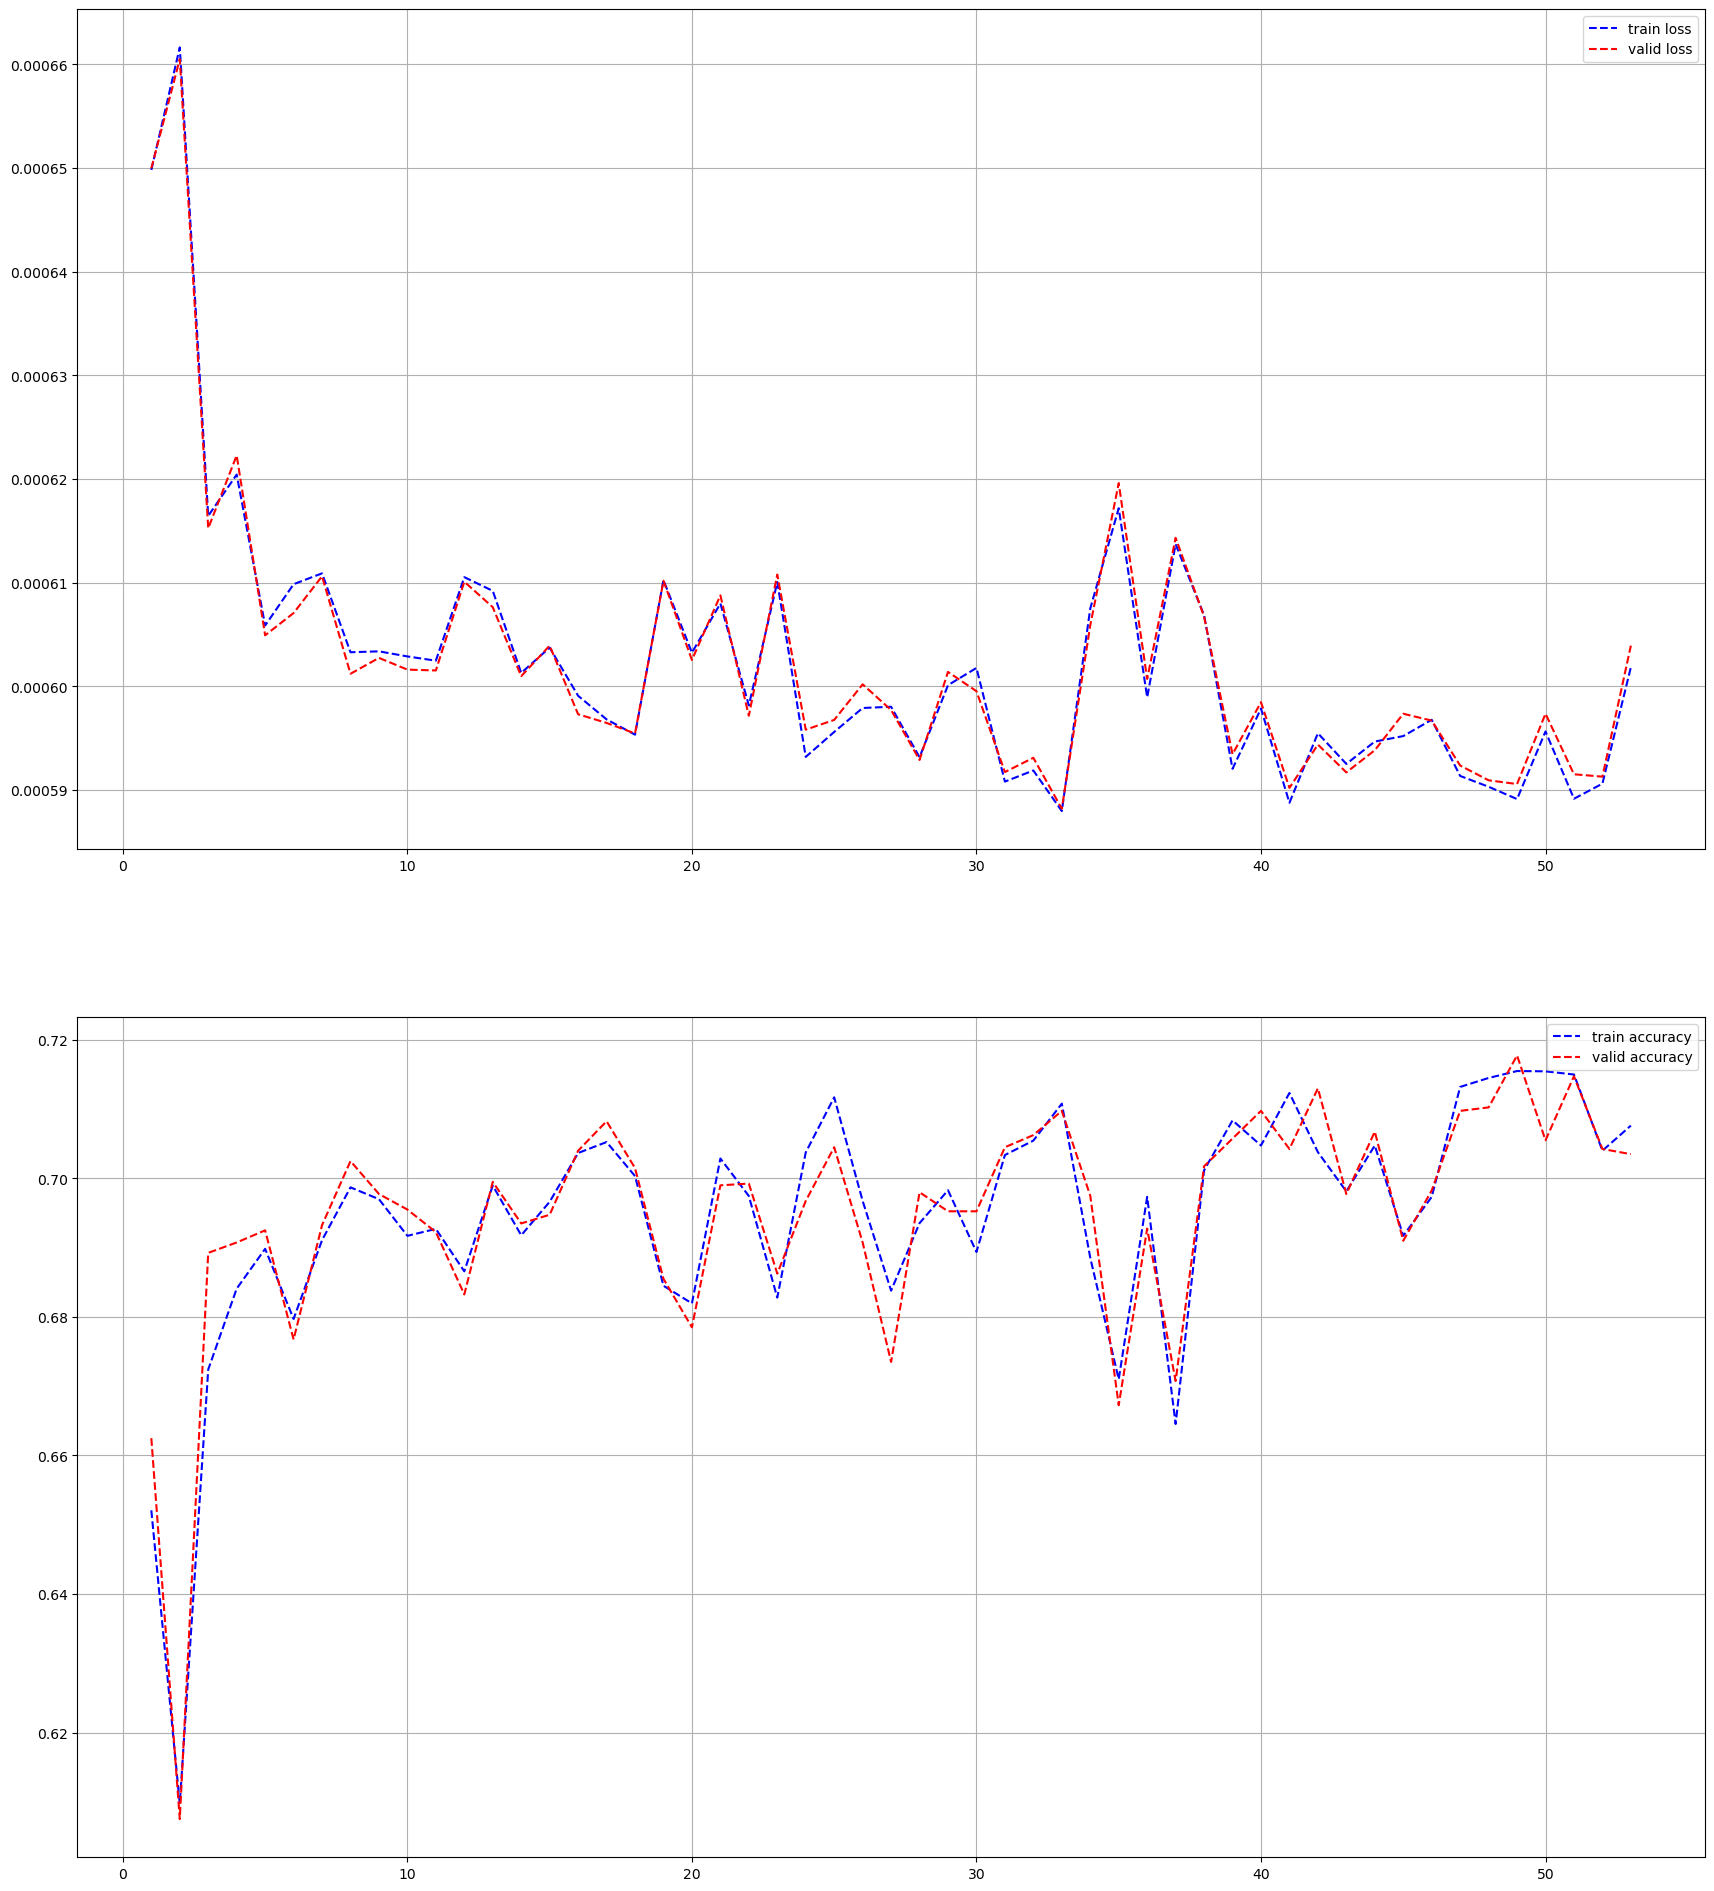

In [42]:
# visualize training steps
# get csv file
modelName, optimizer, initLR, scheduler = eval(csv.loc['0', 'chromosome'])
modelName, optimizer, initLR, scheduler = eval(csv.loc[idx, 'chromosome'])
csvPath = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}/CSV/{modelName}_{optimizer}_initLR-{str(initLR).replace('.', 'p')}_{scheduler}.csv"
record = pd.read_csv(csvPath, index_col=0).transpose()

trainLoss = list(record.loc['loss/train'])
validLoss = list(record.loc['loss/valid'])
trainAcc  = list(record.loc['acc/train'])
validAcc  = list(record.loc['acc/valid'])

plt.figure(figsize=(21, 24))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(trainLoss)+1), trainLoss, "b--", label="train loss")
plt.plot(range(1, len(validLoss)+1), validLoss, "r--", label="valid loss")
plt.legend(loc='best')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(range(1, len(trainAcc)+1), trainAcc, "b--", label="train accuracy")
plt.plot(range(1, len(validAcc)+1), validAcc, "r--", label="valid accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.show()